# Predição da Resistência à Compressão do Concreto utilizando XGBoost

### Trabalho de Conclusão do Curso de Pós-Graduação em Ciência de Dados e *Big Data*

### Autores:
**Diego Alves da Mata** <br>
**Marina dos Santos Coimbra**

# Importando bibliotecas

Aqui se encontra a listagem de todas as bibliotecas utilizadas e os módulos importados para realização deste trabalho.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import plotly.express as px
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn.utils import resample
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelBinarizer, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV

# Leitura dos dados

Aqui está sendo importado o dataset que será utilizado no trabalho e algumas informações sobre ele são listadas abaixo

In [2]:
dados = pd.read_csv("dados_concreto.csv")
dados.drop(["Unnamed: 0", "Unnamed: 0.1"], axis = "columns", inplace=True)
dados.head()

CodigoReceita  Volume TipoLancamento  QuantidadeAgua  ConsumoTotal   FCK  \
0       23009051     8.0              B          1368.0        2480.0  25.0   
1       23009051     8.0              B          1368.0        2480.0  25.0   
2       23009051     8.0              B          1368.0        2480.0  25.0   
3       23009051     8.0              B          1368.0        2480.0  25.0   
4       23009051     8.0              B          1368.0        2480.0  25.0   

   Rompimento7Dias  Rompimento28Dias  ResultadoEsperado  
0            20.66             29.42          43.601321  
1            21.54             32.70          43.601321  
2            18.46             28.26          43.601321  
3            19.59             30.59          43.601321  
4              NaN               NaN          43.601321

In [3]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5197 entries, 0 to 5196
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CodigoReceita      5197 non-null   int64  
 1   Volume             5197 non-null   float64
 2   TipoLancamento     5197 non-null   object 
 3   QuantidadeAgua     5197 non-null   float64
 4   ConsumoTotal       5197 non-null   float64
 5   FCK                5197 non-null   float64
 6   Rompimento7Dias    4743 non-null   float64
 7   Rompimento28Dias   4853 non-null   float64
 8   ResultadoEsperado  5197 non-null   float64
dtypes: float64(7), int64(1), object(1)
memory usage: 365.5+ KB


# Transformação dos Dados

### Transformação das Colunas *QuantidadeAgua* e *ConsumoTotal*

Transformação das colunas para retornarem os valores respectivos para cada m³ de concreto

In [4]:
dados["QuantidadeAguaM3"] = dados["QuantidadeAgua"] / dados["Volume"]

In [5]:
dados["ConsumoM3"] = dados["ConsumoTotal"] / dados["Volume"]

Com a transformação acima, as colunas iniciais se tornam dispensáveis. Abaixo elas são removidas do dataset.

In [6]:
dados.drop(["QuantidadeAgua", "ConsumoTotal"], axis = 1, inplace = True)

### Criação da nova feature *RelacaoAguaCimento*

In [7]:
dados["RelacaoAguaCimento"] = dados["QuantidadeAguaM3"] / dados["ConsumoM3"]
dados["RelacaoAguaCimento"] = dados["RelacaoAguaCimento"].round(2)

In [8]:
dados.tail()

CodigoReceita  Volume TipoLancamento   FCK  Rompimento7Dias  \
5192       39854051     8.0              B  35.0            30.68   
5193       39854051     6.0              B  35.0            31.06   
5194       40479051     7.0              C  25.0            23.02   
5195       29383051     5.5              B  35.0            33.38   
5196       29383051     7.0              B  35.0            31.91   

      Rompimento28Dias  ResultadoEsperado  QuantidadeAguaM3  ConsumoM3  \
5192             46.49          59.801606        155.000000      378.0   
5193             43.00          59.801606        155.000000      378.0   
5194             29.34          33.279130        197.000000      282.0   
5195             45.12          43.571436        187.090909      339.0   
5196             39.63          43.592906        187.000000      339.0   

      RelacaoAguaCimento  
5192                0.41  
5193                0.41  
5194                0.70  
5195                0.55  
5196                0.55

### Removendo dados faltantes da feature que será predita

Como a feature Rompimento28Dias apresenta dados faltantes, estes serão removidos abaixo.

In [9]:
mask_dados_existentes = dados["Rompimento28Dias"].notna()
dados = dados[mask_dados_existentes]

/home/marina/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Rompimento28Dias', ylabel='Density'>

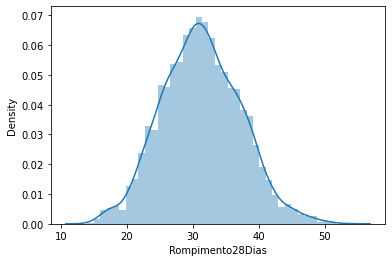

In [10]:
mask_dados_romp_7_dias_existentes = dados["Rompimento28Dias"].notna()
rompimentos_7_dias_existentes = dados[mask_dados_romp_7_dias_existentes]["Rompimento28Dias"]
sns.distplot(rompimentos_7_dias_existentes,kde=True)

In [11]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4853 entries, 0 to 5196
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   CodigoReceita       4853 non-null   int64  
 1   Volume              4853 non-null   float64
 2   TipoLancamento      4853 non-null   object 
 3   FCK                 4853 non-null   float64
 4   Rompimento7Dias     4737 non-null   float64
 5   Rompimento28Dias    4853 non-null   float64
 6   ResultadoEsperado   4853 non-null   float64
 7   QuantidadeAguaM3    4853 non-null   float64
 8   ConsumoM3           4853 non-null   float64
 9   RelacaoAguaCimento  4853 non-null   float64
dtypes: float64(8), int64(1), object(1)
memory usage: 417.1+ KB


**Análise da distribuição dos dados de Rompimento de 7 Dias**

/home/marina/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Rompimento7Dias', ylabel='Density'>

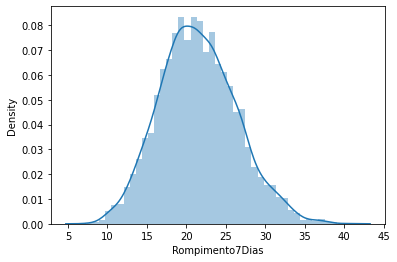

In [12]:
mask_dados_romp_7_dias_existentes = dados["Rompimento7Dias"].notna()
rompimentos_7_dias_existentes = dados[mask_dados_romp_7_dias_existentes]["Rompimento7Dias"]
sns.distplot(rompimentos_7_dias_existentes,kde=True)

**Análise de densidade de amostras por código de receita**

Análise feita a fim de entender como estavam distribuídas as amostras entre os códigos de receita.

/home/marina/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


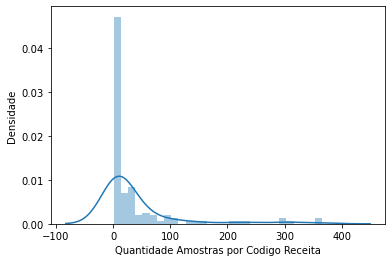

In [13]:
dados_amostras_codigo_receita = dados["CodigoReceita"].value_counts()
fig = sns.distplot(dados_amostras_codigo_receita,kde=True)
fig.set(xlabel='Quantidade Amostras por Codigo Receita', ylabel='Densidade')
plt.show()

In [14]:
print("Total de possíveis categorias na variável CodigoReceita:", len(dados["CodigoReceita"].unique()))

Total de possíveis categorias na variável CodigoReceita: 125


Após esta análise, foi decidido não utilizar tal *feature*.
Abaixo, ela é eliminada do *dataset*.

In [15]:
dados.drop("CodigoReceita", axis = "columns", inplace = True)

**Resultado final após o tratamento dos dados**

In [16]:
dados.head()

Volume TipoLancamento   FCK  Rompimento7Dias  Rompimento28Dias  \
0     8.0              B  25.0            20.66             29.42   
1     8.0              B  25.0            21.54             32.70   
2     8.0              B  25.0            18.46             28.26   
3     8.0              B  25.0            19.59             30.59   
5     8.0              B  25.0            20.19             30.20   

   ResultadoEsperado  QuantidadeAguaM3  ConsumoM3  RelacaoAguaCimento  
0          43.601321             171.0      310.0                0.55  
1          43.601321             171.0      310.0                0.55  
2          43.601321             171.0      310.0                0.55  
3          43.601321             171.0      310.0                0.55  
5          43.601321             171.0      310.0                0.55

In [17]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4853 entries, 0 to 5196
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Volume              4853 non-null   float64
 1   TipoLancamento      4853 non-null   object 
 2   FCK                 4853 non-null   float64
 3   Rompimento7Dias     4737 non-null   float64
 4   Rompimento28Dias    4853 non-null   float64
 5   ResultadoEsperado   4853 non-null   float64
 6   QuantidadeAguaM3    4853 non-null   float64
 7   ConsumoM3           4853 non-null   float64
 8   RelacaoAguaCimento  4853 non-null   float64
dtypes: float64(8), object(1)
memory usage: 379.1+ KB


**Análise da distribuição de amostras nas variáveis categóricas TipoLancamento**

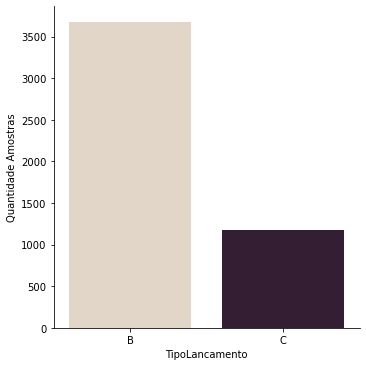

In [18]:
fig = sns.catplot(x='TipoLancamento', kind='count', palette="ch:.25", data=dados)
fig.set(ylabel='Quantidade Amostras')
plt.show()

# Análise Exploratória

Primeiramente, a variável ResultadoEsperado é removida do *dataset* pois será usada somente para comparação do desempenho dos modelos

In [19]:
dados_modelo = dados.drop("ResultadoEsperado", axis = "columns")

In [20]:
dados_modelo.describe()

Volume          FCK  Rompimento7Dias  Rompimento28Dias  \
count  4853.000000  4853.000000      4737.000000       4853.000000   
mean      7.214300    26.350711        21.489770         31.286965   
std       1.094007     4.681115         4.875156          5.989846   
min       3.000000    15.000000         7.410000         14.030000   
25%       7.000000    25.000000        18.090000         27.100000   
50%       8.000000    25.000000        21.230000         31.100000   
75%       8.000000    30.000000        24.670000         35.360000   
max      10.000000    40.000000        40.580000         53.630000   

       QuantidadeAguaM3    ConsumoM3  RelacaoAguaCimento  
count       4853.000000  4853.000000         4853.000000  
mean         170.126786   296.980218            0.580120  
std           18.137238    40.466066            0.079412  
min          112.000000   193.000000            0.380000  
25%          157.000000   271.000000            0.520000  
50%          168.000000   296.000000            0.570000  
75%          183.000000   322.000000            0.620000  
max          219.000000   450.000000            0.930000

In [21]:
dados_modelo.head()

Volume TipoLancamento   FCK  Rompimento7Dias  Rompimento28Dias  \
0     8.0              B  25.0            20.66             29.42   
1     8.0              B  25.0            21.54             32.70   
2     8.0              B  25.0            18.46             28.26   
3     8.0              B  25.0            19.59             30.59   
5     8.0              B  25.0            20.19             30.20   

   QuantidadeAguaM3  ConsumoM3  RelacaoAguaCimento  
0             171.0      310.0                0.55  
1             171.0      310.0                0.55  
2             171.0      310.0                0.55  
3             171.0      310.0                0.55  
5             171.0      310.0                0.55

**Análise de relação entre todas as variáveis numéricas**

O gráfico abaixo possibilita visualizar de forma macro como as variáveis numéricas se relacionam.

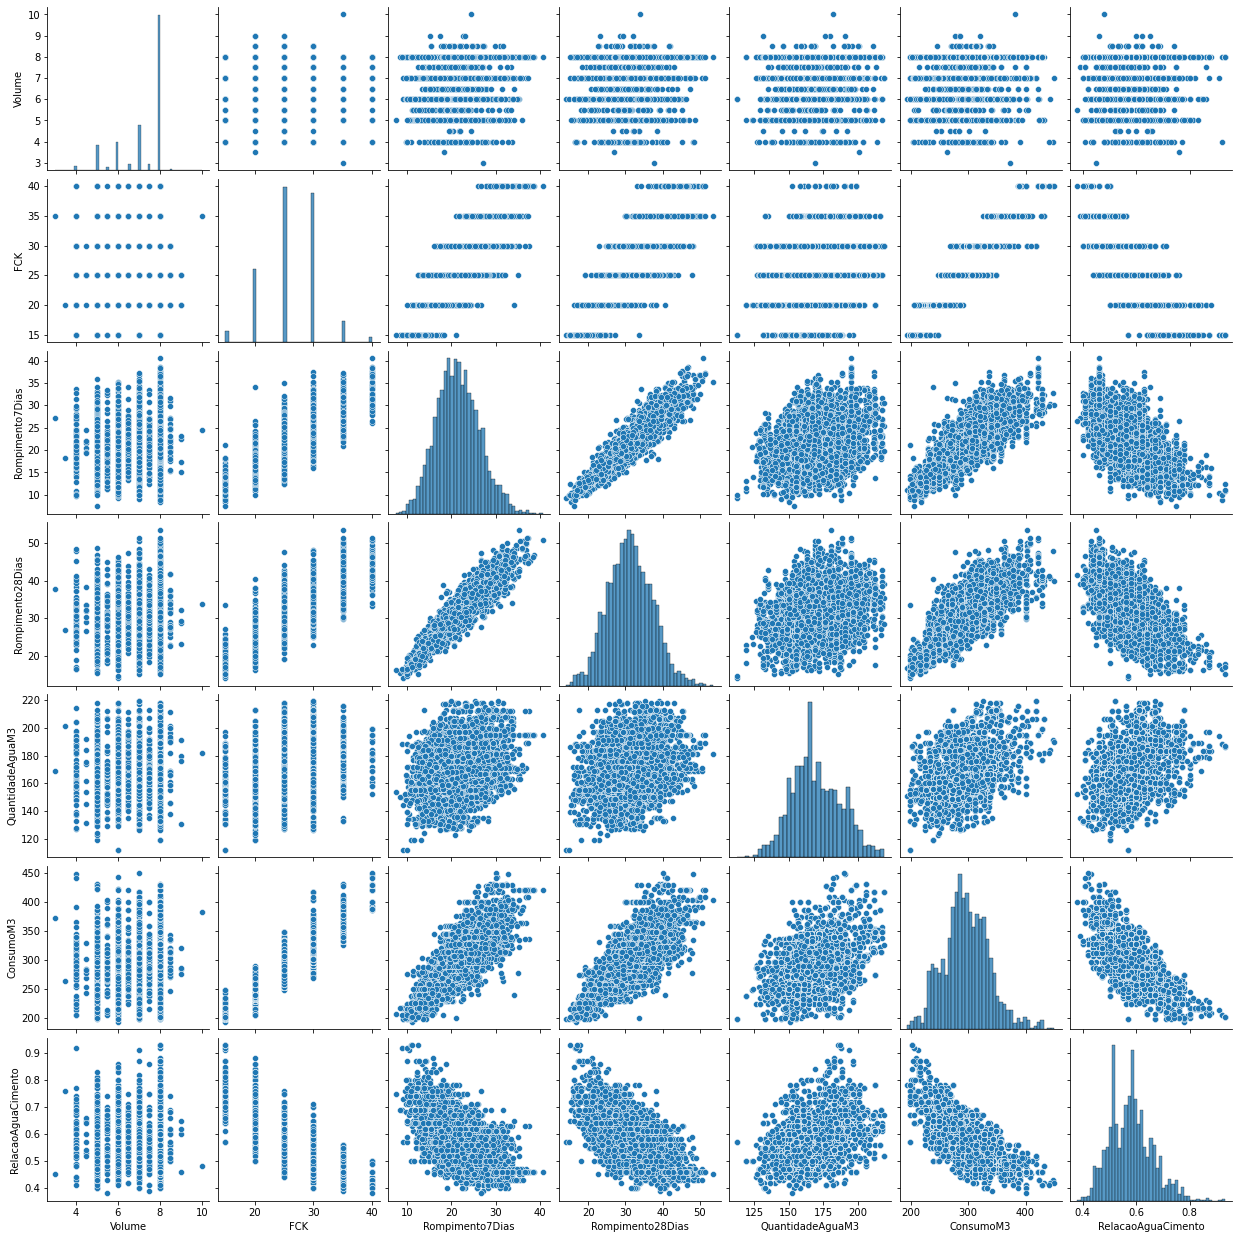

In [22]:
sns.pairplot(dados_modelo)

#### Análise de Correlação entre as variáveis

O gráfico abaixo, chamado de matriz de correlação, ajuda a identificar as correlações entre as *features*.

<AxesSubplot:>

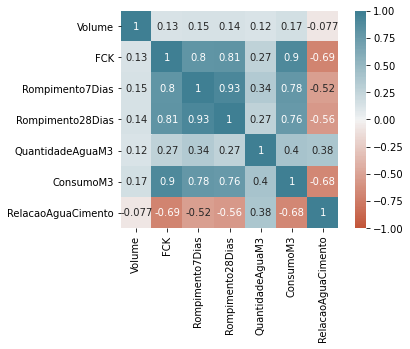

In [23]:
corr = dados_modelo.corr()
sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    annot = True
)

### Análise de Rompimento28Dias

In [24]:
fig = px.box(dados_modelo, y="Rompimento28Dias", width = 500)
fig.show()

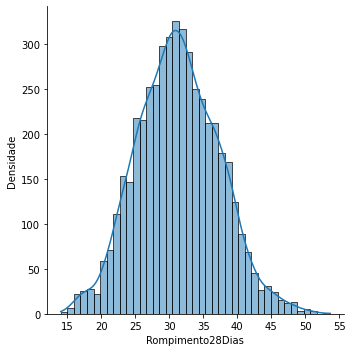

In [25]:
fig = sns.displot(dados_modelo["Rompimento28Dias"], kde=True)
fig.set(ylabel='Densidade')
plt.show()

### Análise de relação entre Rompimento28Dias e demais *features*

##### FCK

Resistência à compressão solicitada pelo cliente

In [26]:
fig = px.box(dados_modelo, x="FCK", y="Rompimento28Dias")
fig.show()

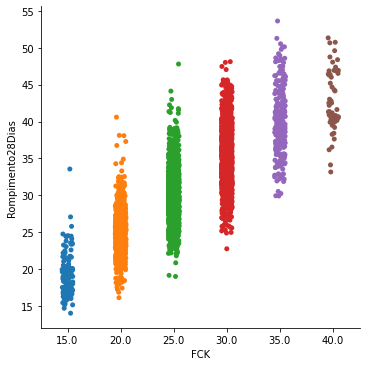

In [27]:
sns.catplot(x="FCK", y="Rompimento28Dias", data=dados_modelo)

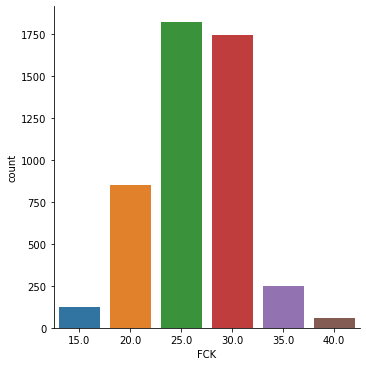

In [28]:
sns.catplot(x="FCK", kind="count", data=dados_modelo)

**Remoção de categorias do FCK**

Pela imagem acima é possível perceber a baixa quantidade de registros para os valores de FCK iguais a 15 e 40. Portanto, estes registros são removidos abaixo.

In [29]:
mask_fck_maior_15 = dados_modelo["FCK"] > 15
mask_fck_menor_40 = dados_modelo["FCK"] < 40

dados_modelo = dados_modelo[mask_fck_maior_15 & mask_fck_menor_40]

##### Rompimento em 7 Dias

Resistência à compressão após 7 dias da moldagem.

In [30]:
fig = px.box(dados_modelo, y="Rompimento7Dias", width = 500)
fig.show()

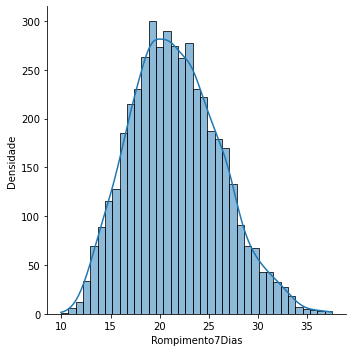

In [31]:
fig = sns.displot(dados_modelo["Rompimento7Dias"], kde=True)
fig.set(ylabel='Densidade')
plt.show()

**Obtenção de rompimentos de 7 e 28 dias separadamente para análise de distribuição das duas variáveis**

Abaixo é definido um método para apenas auxiliar na montagem de um segundo *dataframe* para visualização das distribuições dos rompimentos de 7 e 28 dias em conjunto

In [32]:
def MontaDataFrameRompimentos():
    
    df_romp = pd.DataFrame()
    rompimentos = []
    idades = []
    
    
    for i in range(1, len(dados_modelo)):
        romp7Dias = dados_modelo.iloc[i]["Rompimento7Dias"]
        
        if (romp7Dias == np.NaN):
            continue
        else:
            idades.append(7)
            rompimentos.append(romp7Dias)
            
        romp28Dias = dados_modelo.iloc[i]["Rompimento28Dias"]
        
        if (romp28Dias == np.NaN):
            continue
        else:
            idades.append(28)
            rompimentos.append(romp28Dias)
    
    df_romp["Idade"] = idades
    df_romp["Rompimentos"] = rompimentos
    
    return df_romp

In [33]:
df_romp = MontaDataFrameRompimentos()

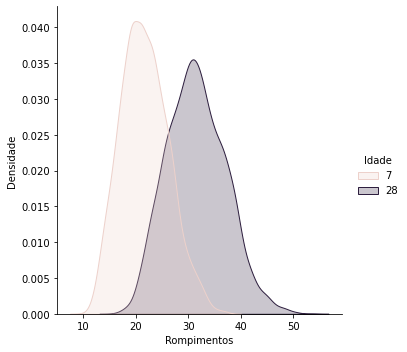

In [34]:
fig = sns.displot(df_romp, x="Rompimentos", hue="Idade", kind="kde", fill=True)
fig.set(ylabel='Densidade')
plt.show()

In [35]:
fig = px.scatter(dados_modelo, x="Rompimento7Dias", y="Rompimento28Dias")
fig.show()

##### Relação Água Cimento

Proporção de água por cimento em um m³ de concreto

In [36]:
fig = px.scatter(dados_modelo, x="RelacaoAguaCimento", y="Rompimento28Dias")
fig.show()

Foi inserida a variável Consumo como legenda na imagem abaixo para analisar o comportamento das três *features* em conjunto.

In [37]:
fig = px.scatter(dados_modelo, x="RelacaoAguaCimento", y="Rompimento28Dias", color = "ConsumoM3")
fig.show()

In [38]:
fig = px.box(dados_modelo, y="RelacaoAguaCimento", width = 500)
fig.show()

##### Consumo m³

Quantitativo de material cimentício em um m³ de concreto

In [39]:
fig = px.scatter(dados_modelo, x="ConsumoM3", y="Rompimento28Dias")
fig.show()

In [40]:
fig = px.box(dados_modelo, y="ConsumoM3", width = 500)
fig.show()

Análise do consumo de material cimentício por valor de FCK.

In [41]:
fig = px.box(dados_modelo, x="FCK", y="ConsumoM3", color="FCK")
fig.show()

##### Tipo de Lançamento

Método de entrega do concreto para o cliente.

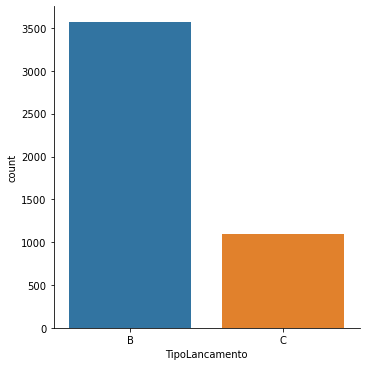

In [42]:
sns.catplot(x="TipoLancamento", kind="count", data=dados_modelo)

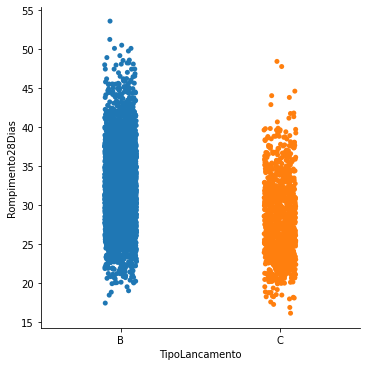

In [43]:
sns.catplot(x="TipoLancamento", y="Rompimento28Dias", data=dados_modelo)

##### Quantidade de água por m³

Quantidade de água em um m³ de concreto.

In [44]:
fig = px.scatter(dados_modelo, x="QuantidadeAguaM3", y="Rompimento28Dias")
fig.show()

In [45]:
fig = px.scatter(dados_modelo, x="QuantidadeAguaM3", y="ConsumoM3")
fig.show()

# Modelagem

In [46]:
dados_modelo.describe()

Volume          FCK  Rompimento7Dias  Rompimento28Dias  \
count  4670.000000  4670.000000      4558.000000       4670.000000   
mean      7.226124    26.485011        21.606483         31.470231   
std       1.087342     4.121896         4.543431          5.593628   
min       3.000000    20.000000         9.940000         16.130000   
25%       7.000000    25.000000        18.310000         27.390000   
50%       8.000000    25.000000        21.320000         31.200000   
75%       8.000000    30.000000        24.645000         35.340000   
max      10.000000    35.000000        37.540000         53.630000   

       QuantidadeAguaM3    ConsumoM3  RelacaoAguaCimento  
count       4670.000000  4670.000000         4670.000000  
mean         170.226994   297.701499            0.577501  
std           18.056942    36.678694            0.074061  
min          119.000000   205.000000            0.390000  
25%          157.000000   271.000000            0.520000  
50%          168.000000   296.000000            0.570000  
75%          183.000000   322.000000            0.620000  
max          219.000000   432.000000            0.880000

Remoção da variável volume do conjunto de *features* para treino, teste e validação do modelo.

In [47]:
dados_modelo.drop("Volume", axis="columns", inplace=True)

/home/marina/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Criação do *dataframe* que guardará as métricas de todos os modelos testados.

In [48]:
metricas = pd.DataFrame(columns=["Modelo", "MSE", "RMSE", "R2", "PercMelhorModelo"])

Reorganização da ordem das colunas no *dataset*.

In [49]:
dados_modelo = dados_modelo[["Rompimento7Dias", "FCK", "QuantidadeAguaM3", "ConsumoM3", "RelacaoAguaCimento", "TipoLancamento", "Rompimento28Dias"]]

Transformação da variável TipoLancamento em categorica.

In [50]:
dados_modelo['TipoLancamento'] = dados_modelo.TipoLancamento.astype('category')
dados_modelo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4670 entries, 0 to 5196
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   Rompimento7Dias     4558 non-null   float64 
 1   FCK                 4670 non-null   float64 
 2   QuantidadeAguaM3    4670 non-null   float64 
 3   ConsumoM3           4670 non-null   float64 
 4   RelacaoAguaCimento  4670 non-null   float64 
 5   TipoLancamento      4670 non-null   category
 6   Rompimento28Dias    4670 non-null   float64 
dtypes: category(1), float64(6)
memory usage: 420.0 KB


### Separação de dados entre treino, validação e teste

In [51]:
X = dados_modelo.drop("Rompimento28Dias", axis="columns")
Y = dados_modelo["Rompimento28Dias"]

x_train, x_test_validation, y_train, y_test_validation = train_test_split(X, Y, test_size=0.3, random_state=42)
x_validation, x_test, y_validation, y_test = train_test_split(x_test_validation, y_test_validation, test_size = 0.5, random_state=45)

In [52]:
print("Tamanho do conjunto de treinamento:", len(x_train))
print("Tamanho do conjunto de validacao:", len(x_validation))
print("Tamanho do conjunto de teste:", len(x_test))

Tamanho do conjunto de treinamento: 3269
Tamanho do conjunto de validacao: 700
Tamanho do conjunto de teste: 701


### Definição de Método para cálculo de Métrica de Negócio

A validação do modelo conta com uma métrica referente ao negócio, que consiste em comparar o desempenho do modelo proposto com o modelo utilizado atualmente pela empresa.

Para isso, é necessário inicialmente obter os resultados esperados para todos os dados de validação utilizados, o que é feito abaixo.

In [53]:
y_re = dados.loc[x_validation.index]["ResultadoEsperado"]

O método **EncontraMelhorModelo** definido abaixo descobre, a partir da análise de todos os itens de validação, qual o modelo se aproximou mais do resultado real.

In [108]:
def EncontraMelhorModelo(y_pred, isTest):
    cont_melhor_pred = 0
    for i in range(0, len(y_re)):
        if (isTest):
            diff_pred = y_pred[i] - y_test.iloc[i]
            diff_re = y_re_test.iloc[i] - y_test.iloc[i]
        else:
            diff_pred = y_pred[i] - y_validation.iloc[i]
            diff_re = y_re.iloc[i] - y_validation.iloc[i]
 
        
        if (diff_pred < diff_re):
            cont_melhor_pred = cont_melhor_pred + 1
    
    perc_acerto = (cont_melhor_pred / len(y_pred)) * 100
    return perc_acerto

### Regressão Linear Simples

Criação de um modelo de regressão linear simples, sem tratamento de outliers.

#### Criação do Pipeline para execução do modelo

In [55]:
class TypeSelector(BaseEstimator, TransformerMixin):
    def __init__(self, dtype):
        self.dtype = dtype
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return X.select_dtypes(include=[self.dtype])

class Encoder(BaseEstimator, TransformerMixin):
    def __init__(self, dtype):
        self.dtype = dtype
    def fit(self, X, y=None):        
        return self
    def transform(self, X):        
        aux = LabelBinarizer().fit(X).transform(X)        
        return aux.reshape(-1,1)
    
class Debug(BaseEstimator, TransformerMixin):
    def __init__(self, dtype):
        self.dtype = dtype
    def fit(self, X, y=None):
        return self
    def transform(self, X):        
        print(X)
    
modelo_ls = Pipeline([
  ('features', FeatureUnion(
      transformer_list=[
          ('numericals', Pipeline([
              ('selector', TypeSelector(np.number)),
              ('fillna', SimpleImputer(strategy="median")),
              ('scaler', MinMaxScaler())
              
          ])),
          ('categoricals', Pipeline([
              ('selector', TypeSelector('category')),            
              ('encoder', Encoder('category')),
              ('scaler', MinMaxScaler())
          ])),
      ]
  )),
  ('model', LinearRegression())
])

#### *Fit* e *Predict*

Abaixo o modelo definido pelo *pipeline* acima é treinado e também é feita a predição dos valores de validação.

In [56]:
modelo_ls.fit(x_train, y_train)
y_pred = modelo_ls.predict(x_validation)

#### Coeficientes

Obtenção dos coeficientes do modelo.

In [57]:
modelo = modelo_ls.named_steps['model']
modelo.coef_

array([24.6914093 ,  4.56905312,  0.90568224, -4.0315409 , -3.40882185,
       -0.48076329])

In [58]:
modelo.intercept_

22.269055487520916

#### Métricas Estatísticas

Obtenção das métricas estatísticas para avaliação de desempenho do modelo.

In [59]:
mse = metrics.mean_squared_error(y_validation, y_pred)
rmse = metrics.mean_squared_error(y_validation, y_pred, squared=False)
r2 = metrics.r2_score(y_validation, y_pred)

metricas = metricas.append({'Modelo': 'LinearSimples', 'MSE': round(mse, 3), 'RMSE': round(rmse, 3), 'R2': round(r2, 3)}, ignore_index=True)
metricas

Modelo    MSE   RMSE     R2  PercMelhorModelo
0  LinearSimples  4.822  2.196  0.846               NaN

#### Métrica de Negócio

Obtenção da métrica de negócio para comparação entre métodos.

In [60]:
perc_acerto = EncontraMelhorModelo(y_pred)
metricas.iloc[0, 4] = perc_acerto
metricas

Modelo    MSE   RMSE     R2  PercMelhorModelo
0  LinearSimples  4.822  2.196  0.846              98.0

### Remoção de *Outliers*

Serão removidos os *outliers* de 4 colunas do *dataset*: Rompimento7Dias, QuantidadeAguaM3, ConsumoM3 e RelacaoAguaCimento, a partir de um subconjunto de dados segregados pelos valores de FCK.

Definição dos métodos que definem e removem os registro considerados *outliers*.

In [61]:
def EncontraIndicesOutliers(x):
    
    cols = ['Rompimento7Dias', 'QuantidadeAguaM3', 'ConsumoM3', 'RelacaoAguaCimento']
    outliers = pd.DataFrame()
    
    indices = []
    fcks = x["FCK"].unique()

    for fck in fcks:

        dados_fck = x[x["FCK"] == fck]
        
        for column in cols:
        
            Q1 = dados_fck[column].quantile(0.25)
            Q3 = dados_fck[column].quantile(0.75)
            IQR = Q3 - Q1

            outliers = dados_fck[((dados_fck[column] < (Q1 - 2 * IQR)) |(dados_fck[column] > (Q3 + 2 * IQR)))]
            indices.extend(outliers.index)
    
    indices_unicos = list(set(indices))
    return indices_unicos

def RemoveOutliersPorIndice_X(x, indices_unicos):
    return x.drop(indices_unicos)
    
def RemoveOutliersPorIndice_Y(y, indices_unicos):
    return y.drop(indices_unicos)

Remoção dos *outliers* nos dados de treinamento.

In [62]:
indices = EncontraIndicesOutliers(x_train)

x_train_lso = RemoveOutliersPorIndice_X(x_train, indices)
y_train_lso = RemoveOutliersPorIndice_Y(y_train, indices)

### Regressão Linear Simples Após a Remoção de Outliers

Criação de um modelo de regressão linear simples com o tratamento de outliers.

#### Criação do Pipeline para execução do modelo

In [63]:
modelo_lso = Pipeline([
  ('features', FeatureUnion(      
      transformer_list=[
          ('numericals', Pipeline([
              ('selector', TypeSelector(np.number)),
              ('fillna', SimpleImputer(strategy="median")),
              ('scaler', MinMaxScaler())
              
          ])),
          ('categoricals', Pipeline([
              ('selector', TypeSelector('category')),            
              ('encoder', Encoder('category')),
              ('scaler', MinMaxScaler())
          ])),          
      ]
  )),
  ('model', LinearRegression())
])

#### *Fit* e *Predict*

Abaixo o modelo definido pelo *pipeline* acima é treinado e também é feita a predição dos valores de validação.

In [64]:
modelo_lso.fit(x_train_lso, y_train_lso)
y_pred_lso = modelo_lso.predict(x_validation)

#### Métricas Estatísticas

Obtenção das métricas estatísticas para avaliação de desempenho do modelo.

In [65]:
mse = metrics.mean_squared_error(y_validation, y_pred_lso)
rmse = metrics.mean_squared_error(y_validation, y_pred_lso, squared=False)
r2 = metrics.r2_score(y_validation, y_pred_lso)

metricas = metricas.append({'Modelo': 'LinearSimples Sem Outliers', 'MSE': round(mse,3), 'RMSE': round(rmse,3), 'R2': round(r2,3)}, ignore_index=True)
metricas

Modelo    MSE   RMSE     R2  PercMelhorModelo
0               LinearSimples  4.822  2.196  0.846              98.0
1  LinearSimples Sem Outliers  4.835  2.199  0.846               NaN

**Métrica de Negócio**

Obtenção da métrica de negócio para comparação entre métodos.

In [66]:
perc_acerto = EncontraMelhorModelo(y_pred_lso)
metricas.iloc[1, 4] = perc_acerto
metricas

Modelo    MSE   RMSE     R2  PercMelhorModelo
0               LinearSimples  4.822  2.196  0.846              98.0
1  LinearSimples Sem Outliers  4.835  2.199  0.846              98.0

### Modelo XGBoost

#### Criação do Pipeline para execução do modelo

In [67]:
modelo_xgb = Pipeline([
  ('features', FeatureUnion(      
      transformer_list=[
          ('numericals', Pipeline([
              ('selector', TypeSelector(np.number)),
              ('fillna', SimpleImputer(strategy="median")),
              ('scaler', MinMaxScaler())
              
          ])),
          ('categoricals', Pipeline([
              ('selector', TypeSelector('category')),            
              ('encoder', Encoder('category')),
              ('scaler', MinMaxScaler())
          ])),          
      ]
  )),
  ('model', xgb.XGBRegressor(random_state = 21))
])

#### *Fit* e *Predict*

Abaixo o modelo definido pelo *pipeline* acima é treinado e também é feita a predição dos valores de validação.

In [68]:
modelo_xgb.fit(x_train, y_train)
y_pred_xgb = modelo_xgb.predict(x_validation)

#### Métricas Estatísticas

Obtenção das métricas estatísticas para avaliação de desempenho do modelo.

In [69]:
mse = metrics.mean_squared_error(y_validation, y_pred_xgb)
rmse = metrics.mean_squared_error(y_validation, y_pred_xgb, squared=False)
r2 = metrics.r2_score(y_validation, y_pred_xgb)

metricas = metricas.append({'Modelo': 'XGBRegressor', 'MSE': round(mse,3), 'RMSE': round(rmse,3), 'R2': round(r2,3)}, ignore_index=True)
metricas

Modelo    MSE   RMSE     R2  PercMelhorModelo
0               LinearSimples  4.822  2.196  0.846              98.0
1  LinearSimples Sem Outliers  4.835  2.199  0.846              98.0
2                XGBRegressor  4.120  2.030  0.869               NaN

**Métrica de Negócio**

Obtenção da métrica de negócio para comparação entre métodos.

In [70]:
perc_acerto = EncontraMelhorModelo(y_pred_xgb)
metricas.iloc[2, 4] = perc_acerto
metricas

Modelo    MSE   RMSE     R2  PercMelhorModelo
0               LinearSimples  4.822  2.196  0.846              98.0
1  LinearSimples Sem Outliers  4.835  2.199  0.846              98.0
2                XGBRegressor  4.120  2.030  0.869              98.0

### Modelo XGBoost com Ajuste de Parâmetros

Definição da faixa de busca para o ajuste de parâmetros do algoritmo *XGBRegressor*

In [71]:
parameters = {
    'n_estimators': np.arange(80, 100, 4),
    'learning_rate': np.arange(0.2, 0.7, 0.1),
    'objective': ('reg:squarederror', 'reg:squaredlogerror'),
    'max_depth': np.arange(1, 6, 1)
}

#### Criação do Pipeline para execução do modelo

In [72]:
modelo_xgb_ot = Pipeline([
  ('features', FeatureUnion(      
      transformer_list=[
          ('numericals', Pipeline([
              ('selector', TypeSelector(np.number)),
              ('fillna', SimpleImputer(strategy="median")),
              ('scaler', MinMaxScaler())
              
          ])),
          ('categoricals', Pipeline([
              ('selector', TypeSelector('category')),            
              ('encoder', Encoder('category')),
              ('scaler', MinMaxScaler())
          ])),          
      ]
  )),
  ('model', GridSearchCV(estimator = xgb.XGBRegressor(random_state = 1), 
                         param_grid = parameters,
                         scoring = 'neg_mean_squared_error'))
])

#### *Fit* e *Predict*

Abaixo o modelo definido pelo *pipeline* acima é treinado e também é feita a predição dos valores de validação.

In [73]:
modelo_xgb_ot.fit(x_train, y_train)
y_pred_xgb_ot = modelo_xgb_ot.predict(x_validation)

#### Métricas Estatísticas 

Obtenção das métricas estatísticas para avaliação de desempenho do modelo.

In [74]:
mse = metrics.mean_squared_error(y_validation, y_pred_xgb_ot)
rmse = metrics.mean_squared_error(y_validation, y_pred_xgb_ot, squared=False)
r2 = metrics.r2_score(y_validation, y_pred_xgb_ot)

metricas = metricas.append({'Modelo': 'XGBRegressor Com Ajuste de Hiperparametros', 'MSE': round(mse,3), 'RMSE': round(rmse,3), 'R2': round(r2,3)}, ignore_index=True)
metricas

Modelo    MSE   RMSE     R2  \
0                               LinearSimples  4.822  2.196  0.846   
1                  LinearSimples Sem Outliers  4.835  2.199  0.846   
2                                XGBRegressor  4.120  2.030  0.869   
3  XGBRegressor Com Ajuste de Hiperparametros  4.020  2.005  0.872   

   PercMelhorModelo  
0              98.0  
1              98.0  
2              98.0  
3               NaN

**Métrica de Negócio**

Obtenção da métrica de negócio para comparação entre métodos.

In [75]:
perc_acerto = EncontraMelhorModelo(y_pred_xgb_ot)
metricas.iloc[3, 4] = round(perc_acerto,3)
metricas

Modelo    MSE   RMSE     R2  \
0                               LinearSimples  4.822  2.196  0.846   
1                  LinearSimples Sem Outliers  4.835  2.199  0.846   
2                                XGBRegressor  4.120  2.030  0.869   
3  XGBRegressor Com Ajuste de Hiperparametros  4.020  2.005  0.872   

   PercMelhorModelo  
0            98.000  
1            98.000  
2            98.000  
3            98.429

**Melhores parâmetros obtidos pelo *GridSearchCV***

In [76]:
modelo_xgb_ot['model'].best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.2, max_delta_step=0, max_depth=5,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=96, n_jobs=0, num_parallel_tree=1, random_state=1,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

#### Análise de Desempenho do Modelo por Classe das *Features* categóricas

Definição dos métodos que calculam o percentual de vezes em que o modelo proposto teve desempenho superior ao método utilizado atualmente, segregado por classe de uma *feature* definida.

In [104]:
def EncontraPercentualMelhorPorClasse(ind_classe, valor, x, y, y_pred, y_re):
    print(len(x))

    for i in range(0, len(x)):
        if (x.iloc[i,ind_classe] == valor):
            indices_pred.append(i)
            indices_re.append(x.iloc[i].name)
    
    #itens_da_classe = list(filter(lambda item: item.iloc[i,ind_classe] == valor, x))
    #return itens_da_classe
    #indices_re = list(filter(lambda item: item.iloc[i,ind_classe] == valor, x))
    
    y_pred_classe = y_pred[indices_pred]
    y_re_classe = y_re.loc[indices_re]
    
    return EncontraMelhorModeloPorClasse(y_pred_classe, y_re_classe, y)
    
    
def EncontraMelhorModeloPorClasse(y_pred, y_re, y_validation):
    cont_melhor_pred = 0
    for i in range(0, len(y_re)):
        diff_pred = y_pred[i] - y_validation.iloc[i]
        diff_re = y_re.iloc[i] - y_validation.iloc[i]
        if (diff_pred < diff_re):
            cont_melhor_pred = cont_melhor_pred + 1
    
    perc_acerto = (cont_melhor_pred / len(y_pred)) * 100
    return perc_acerto


#### Métricas do modelo por classe

***Tipo Lançamento***

In [78]:
perc_melhor_bomb = EncontraPercentualMelhorPorClasse(5, "B", x_validation, y_validation, y_pred_xgb_ot, y_re)
perc_melhor_conv = EncontraPercentualMelhorPorClasse(5, "C", x_validation, y_validation, y_pred_xgb_ot, y_re)

pd.DataFrame(data=[
    {"Classe": "Bombeável", "Resultado (%)": round(perc_melhor_bomb,1)},
    {"Classe": "Convencional", "Resultado (%)": round(perc_melhor_conv,1)}
], columns=["Classe", "Resultado (%)"])

Classe  Resultado (%)
0     Bombeável           98.1
1  Convencional           99.4

***FCK***

In [79]:
perc_melhor_fck_20 = EncontraPercentualMelhorPorClasse(1, 20, x_validation, y_validation, y_pred_xgb_ot, y_re)
perc_melhor_fck_25 = EncontraPercentualMelhorPorClasse(1, 25, x_validation, y_validation, y_pred_xgb_ot, y_re)
perc_melhor_fck_30 = EncontraPercentualMelhorPorClasse(1, 30, x_validation, y_validation, y_pred_xgb_ot, y_re)
perc_melhor_fck_35 = EncontraPercentualMelhorPorClasse(1, 35, x_validation, y_validation, y_pred_xgb_ot, y_re)

pd.DataFrame(data=[
    {"Classe": "FCK 20", "Resultado (%)": round(perc_melhor_fck_20,1)},
    {"Classe": "FCK 25", "Resultado (%)": round(perc_melhor_fck_25,1)},
    {"Classe": "FCK 30", "Resultado (%)": round(perc_melhor_fck_30,1)},
    {"Classe": "FCK 35", "Resultado (%)": round(perc_melhor_fck_35,1)},
], columns=["Classe", "Resultado (%)"])

Classe  Resultado (%)
0  FCK 20           96.8
1  FCK 25           99.6
2  FCK 30           98.6
3  FCK 35           94.6

### Validação do Modelo com Dados de Teste

***Predict***

In [80]:
y_pred_xgb_ot_test = modelo_xgb_ot.predict(x_test)

#### Métricas Estatísticas

Obtenção das métricas estatísticas para avaliação de desempenho do modelo.

In [81]:
metricas_teste = pd.DataFrame(columns=["Modelo", "MSE", "RMSE", "R2", "PercMelhorModelo"])

mse = metrics.mean_squared_error(y_test, y_pred_xgb_ot_test)
rmse = metrics.mean_squared_error(y_test, y_pred_xgb_ot_test, squared=False)
r2 = metrics.r2_score(y_test, y_pred_xgb_ot_test)

metricas_teste = metricas_teste.append({'Modelo': 'XGBRegressor Com Ajuste de Hiperparametros - Teste', 'MSE': round(mse,3), 'RMSE': round(rmse,3), 'R2': round(r2,3)}, ignore_index=True)
metricas_teste

Modelo   MSE   RMSE     R2  \
0  XGBRegressor Com Ajuste de Hiperparametros - T...  3.68  1.918  0.874   

   PercMelhorModelo  
0               NaN

**Métrica de Negócio**

Obtenção da métrica de negócio para comparação entre métodos.

In [109]:
perc_acerto = EncontraMelhorModelo(y_pred_xgb_ot_test, True)
metricas_teste.iloc[0, 4] = round(perc_acerto,3)
metricas_teste

Modelo   MSE   RMSE     R2  \
0  XGBRegressor Com Ajuste de Hiperparametros - T...  3.68  1.918  0.874   

   PercMelhorModelo  
0            98.859

**Métricas do modelo por classe**

In [83]:
y_re_test = dados.loc[x_test.index]["ResultadoEsperado"]

***Tipo de Lançamento***

In [84]:
perc_melhor_bomb = EncontraPercentualMelhorPorClasse(5, "B", x_test, y_test, y_pred_xgb_ot_test, y_re_test)
perc_melhor_conv = EncontraPercentualMelhorPorClasse(5, "C", x_test, y_test, y_pred_xgb_ot_test, y_re_test)

pd.DataFrame(data=[
    {"Classe": "Bombeável", "Resultado (%)": round(perc_melhor_bomb,1)},
    {"Classe": "Convencional", "Resultado (%)": round(perc_melhor_conv,1)}
], columns=["Classe", "Resultado (%)"])

Classe  Resultado (%)
0     Bombeável           99.3
1  Convencional           98.1

**FCK**

In [85]:
perc_melhor_fck_20 = EncontraPercentualMelhorPorClasse(1, 20, x_test, y_test, y_pred_xgb_ot_test, y_re_test)
perc_melhor_fck_25 = EncontraPercentualMelhorPorClasse(1, 25, x_test, y_test, y_pred_xgb_ot_test, y_re_test)
perc_melhor_fck_30 = EncontraPercentualMelhorPorClasse(1, 30, x_test, y_test, y_pred_xgb_ot_test, y_re_test)
perc_melhor_fck_35 = EncontraPercentualMelhorPorClasse(1, 35, x_test, y_test, y_pred_xgb_ot_test, y_re_test)

pd.DataFrame(data=[
    {"Classe": "FCK 20", "Resultado (%)": round(perc_melhor_fck_20,1)},
    {"Classe": "FCK 25", "Resultado (%)": round(perc_melhor_fck_25,1)},
    {"Classe": "FCK 30", "Resultado (%)": round(perc_melhor_fck_30,1)},
    {"Classe": "FCK 35", "Resultado (%)": round(perc_melhor_fck_35,1)},
], columns=["Classe", "Resultado (%)"])

Classe  Resultado (%)
0  FCK 20           98.4
1  FCK 25           98.9
2  FCK 30           99.3
3  FCK 35          100.0

In [105]:
perc_melhor_bomb = EncontraPercentualMelhorPorClasse(5, "B", x_test, y_test, y_pred_xgb_ot_test, y_re_test)

701
Rompimento7Dias       23.27
FCK                      25
QuantidadeAguaM3        173
ConsumoM3               308
RelacaoAguaCimento     0.56
TipoLancamento            B
Name: 4435, dtype: object


In [96]:
perc_melhor_bomb = EncontraPercentualMelhorPorClasse(5, "C", x_test, y_test, y_pred_xgb_ot_test, y_re_test)

701
1396     True
3701     True
2623     True
4435    False
1605    False
        ...  
917     False
163     False
57      False
617     False
4453    False
Name: TipoLancamento, Length: 701, dtype: bool
